In [15]:
%cd C:\Users\carol\Desktop\asset_allocation\HRP

C:\Users\carol\Desktop\asset_allocation\HRP


In [16]:
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt
import matplotlib
import copy
import pandas as pd
plt.style.use('ggplot')

import numpy as np
%matplotlib inline

### Step 0: Sample Data (ETFs)

In [17]:
price_data = pd.read_csv('C:\\Users\\carol\\Desktop\wdata.csv', index_col=0)
in_start_date = '2013-07-29'
in_end_date = '2020-12-17'
in_sample = price_data[(price_data.index >= in_start_date ) & (price_data.index < in_end_date)]
return_data = in_sample.pct_change().dropna()

### Step 1: Tree Clustering 

In [18]:
corr = return_data.corr()
cov = return_data.cov()

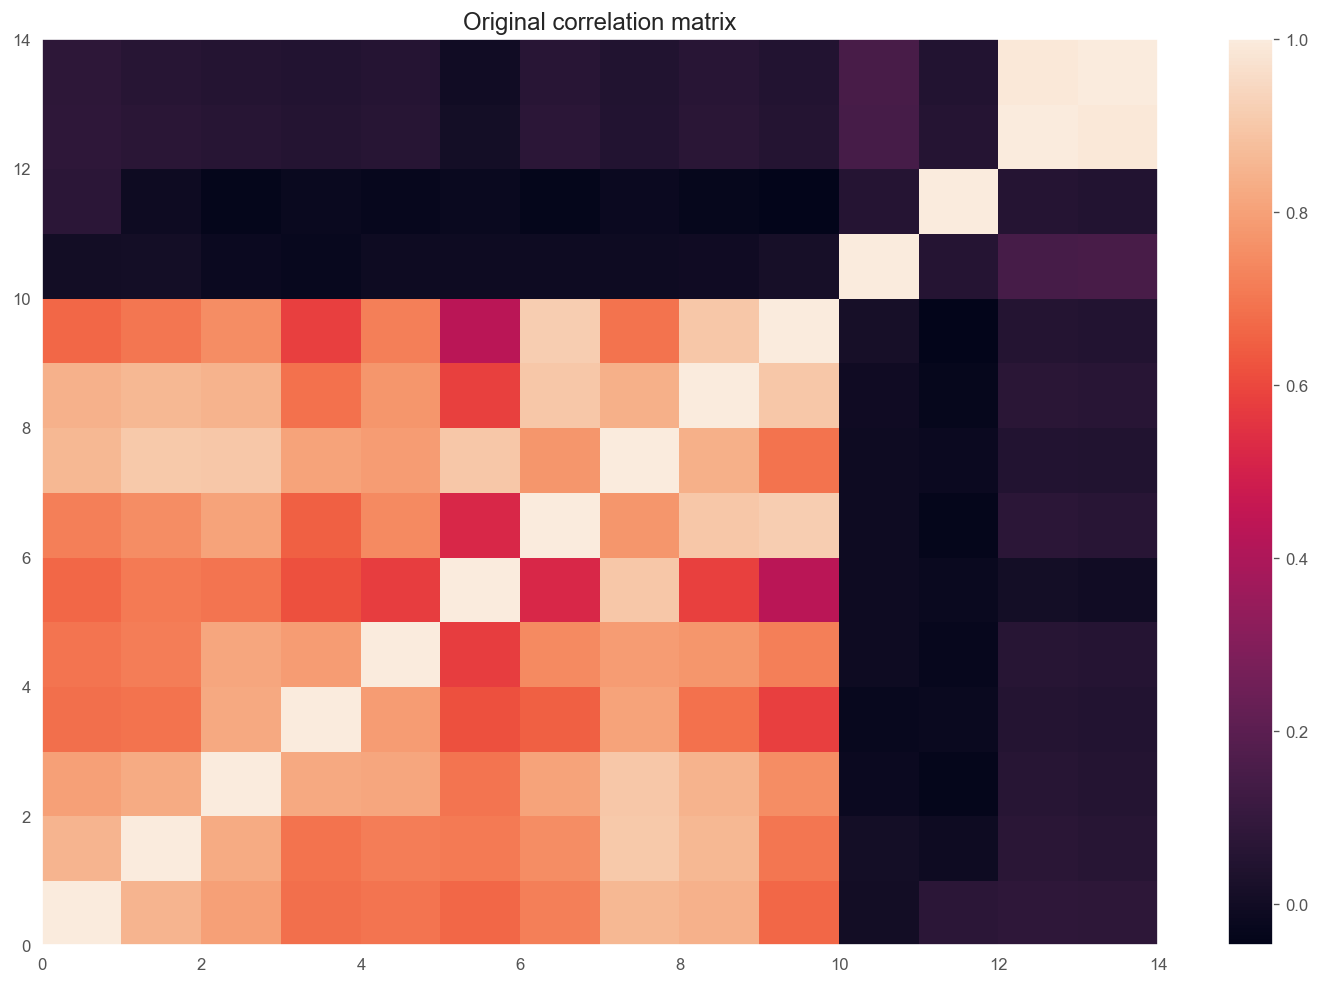

In [19]:
plt.figure(figsize=(15,10),dpi=120)
plt.pcolormesh(corr)
plt.colorbar()
plt.title('Original correlation matrix')
plt.show()


In [20]:
# Distance Measure of original correlation matrix
d = np.sqrt((1 - corr) / 2)

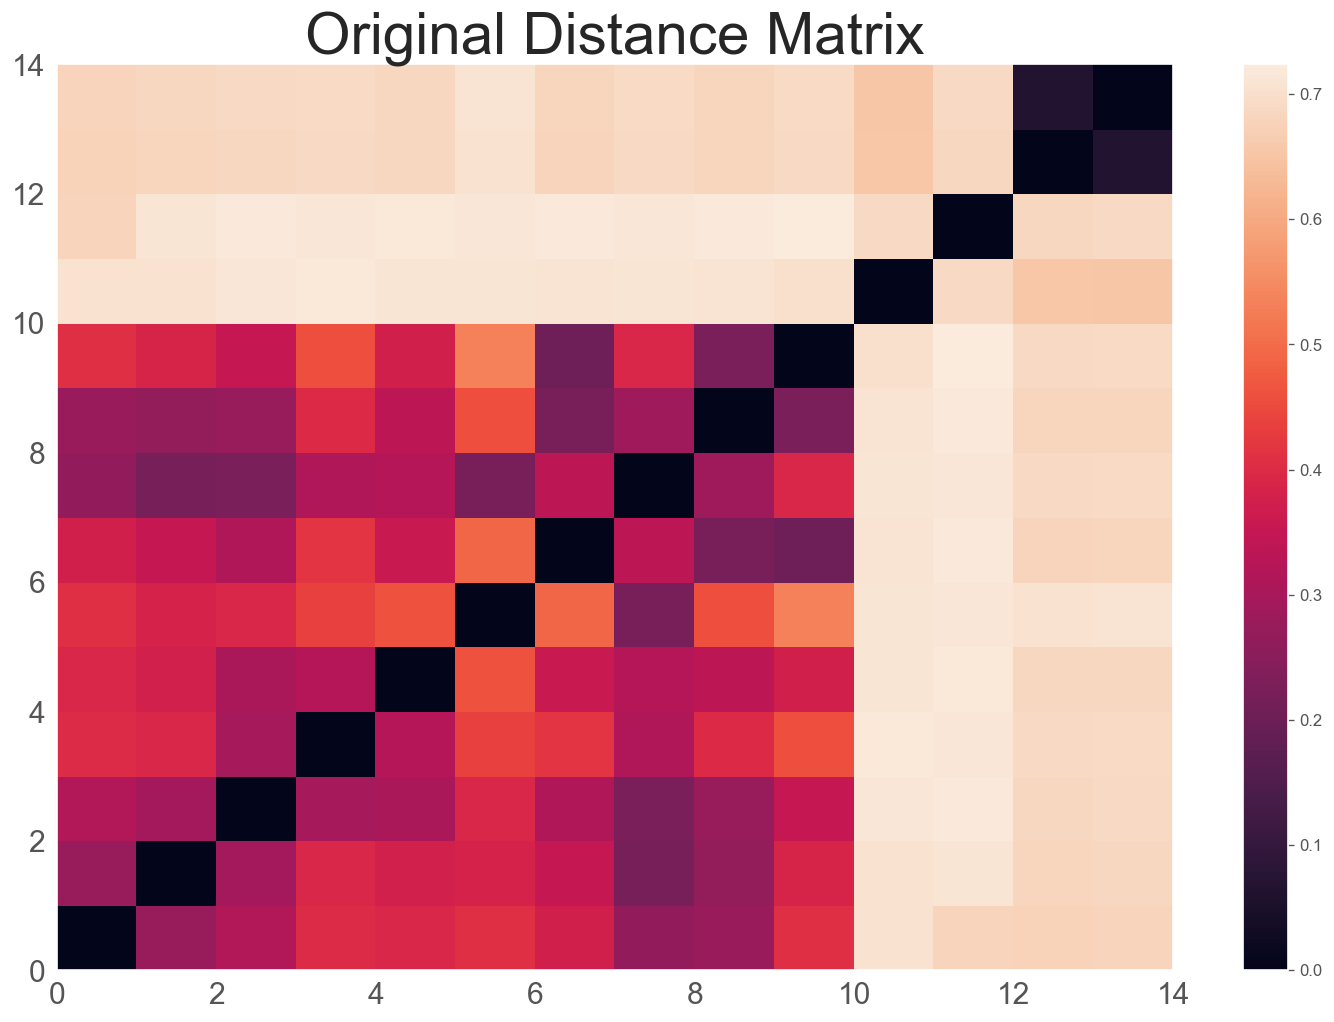

In [21]:
plt.figure(figsize=(15,10),dpi=120)
plt.pcolormesh(d)
plt.colorbar()
plt.title('Original Distance Matrix', fontsize=35)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

In [22]:
def tree_clustering(dist_mat, method="single", metric =  'eculidean'):
    flat_dist_mat = squareform(dist_mat) # 转为一维的distance array
    res_linkage = linkage(flat_dist_mat, method=method, metric = metric)
    return res_linkage

res_linkage = tree_clustering(d)

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

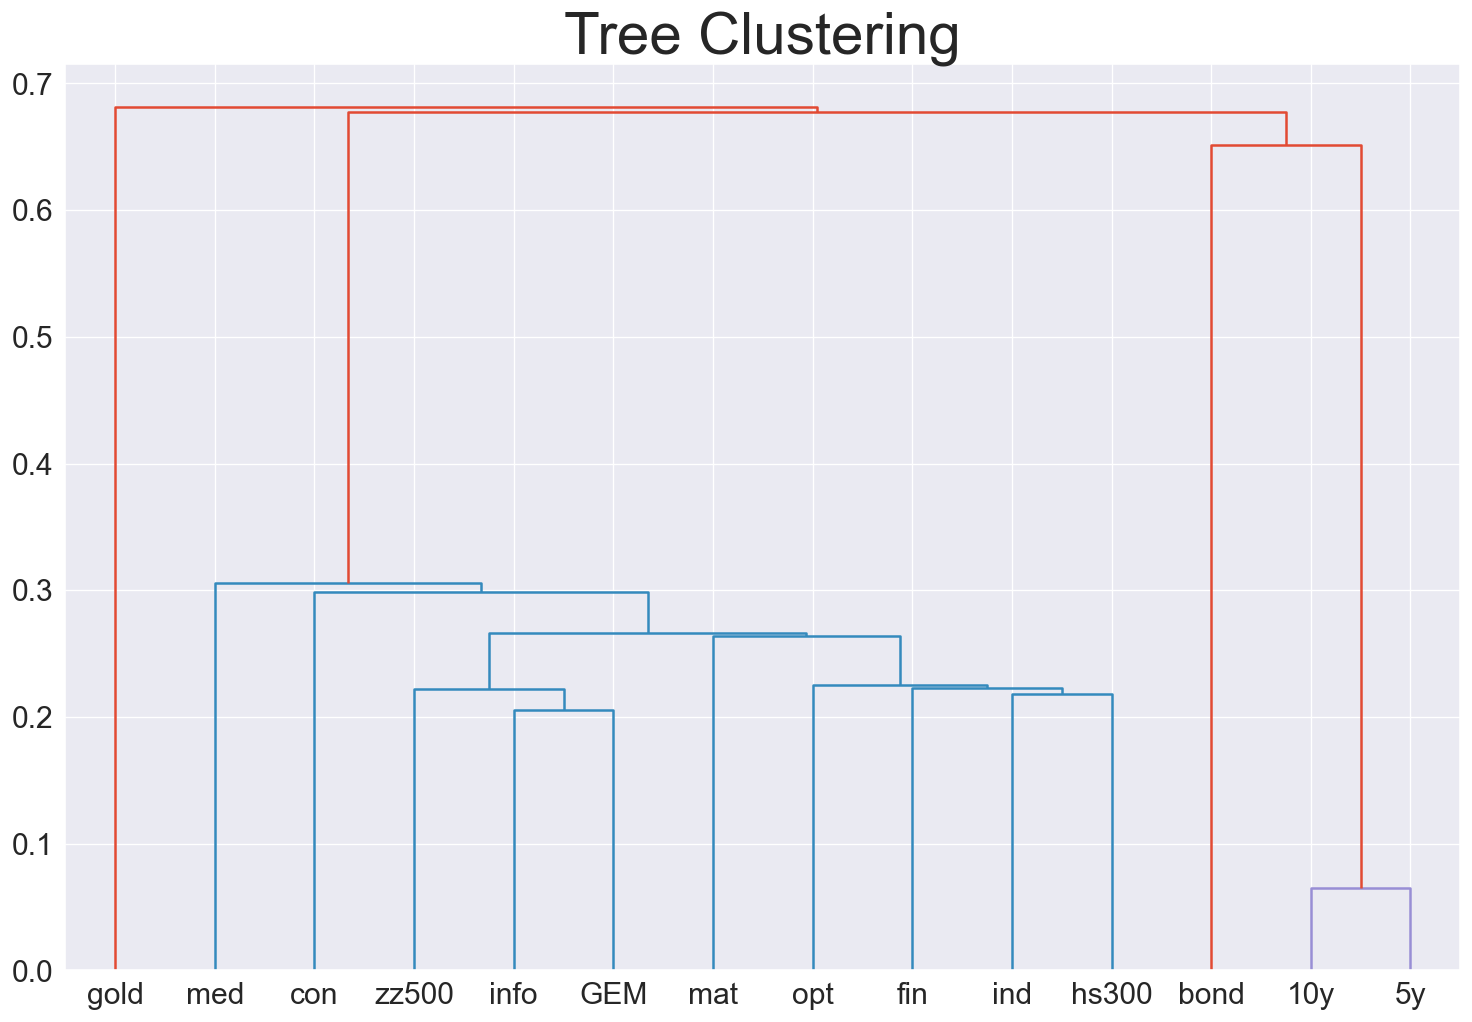

In [23]:
import seaborn as sns
# sns.set_context("talk")
sns.set_style("darkgrid")
plt.figure(figsize=(15,10),dpi=120)
dn = dendrogram(res_linkage, labels=corr.index.values) 
plt.title('Tree Clustering', fontsize=35)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)


### Step 2: Quasi diagonalization

In [24]:
def seriation(Z, N, cur_index):
    """Returns the order implied by a hierarchical tree (dendrogram).
    
       :param Z: A hierarchical tree (dendrogram).
       :param N: The number of points given to the clustering process.
       :param cur_index: The position in the tree for the recursive traversal.
       
       :return: The order implied by the hierarchical tree Z.
    """
    if cur_index < N:
        return [cur_index]
    else:
        left = int(Z[cur_index - N, 0])
        right = int(Z[cur_index - N, 1])
        return (seriation(Z, N, left) + seriation(Z, N, right))

def compute_serial_matrix(dist_mat, method="single"):
    """Returns a sorted distance matrix.
    
       :param dist_mat: A distance matrix.
       :param method: A string in ["ward", "single", "average", "complete"].
        
        output:
            - seriated_dist is the input dist_mat,
              but with re-ordered rows and columns
              according to the seriation, i.e. the
              order implied by the hierarchical tree
            - res_order is the order implied by
              the hierarhical tree
            - res_linkage is the hierarhical tree (dendrogram)
        
        compute_serial_matrix transforms a distance matrix into 
        a sorted distance matrix according to the order implied 
        by the hierarchical tree (dendrogram)
    """
    N = len(dist_mat)
    flat_dist_mat = squareform(dist_mat)
    
    res_linkage = linkage(flat_dist_mat, method=method)
    res_order = seriation(res_linkage, N, N + N - 2)
    
    seriated_dist = np.zeros((N, N)) # 构建一个新的空矩阵，填入新的ordered元素
    a,b = np.triu_indices(N, k=1)
    
    seriated_dist[a,b] = dist_mat[[res_order[i] for i in a], [res_order[j] for j in b]]
    seriated_dist[b,a] = seriated_dist[a,b] # 对角线为0
    
    return seriated_dist, res_order, res_linkage    

ordered_dist_mat, res_order, res_linkage = compute_serial_matrix(d.values)

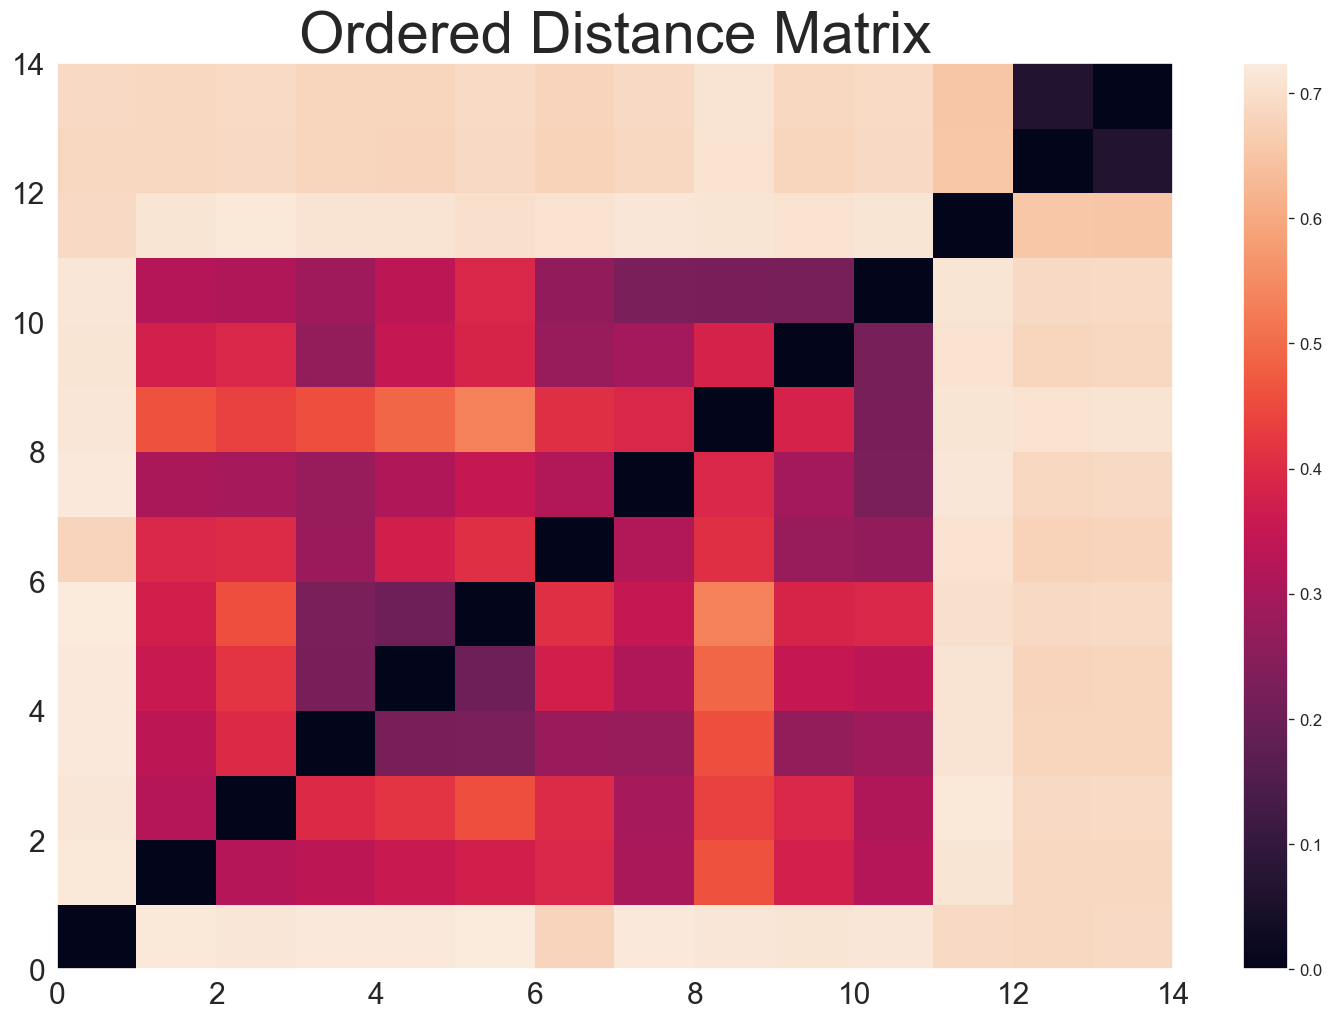

In [25]:
plt.figure(figsize=(15,10),dpi=120)
plt.pcolormesh(ordered_dist_mat)
plt.colorbar()
plt.title('Ordered Distance Matrix', fontsize=35)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.show()

### Step 3 Recursive Bisection

In [26]:
def compute_HRP_weights(covariances, res_order):
    weights = pd.Series(1, index=res_order)
    clustered_lists = [res_order] 
    while len(clustered_lists) > 0:
            # Bisect：将clustered_lists分为两个list
            clustered_lists = [cluster[start:end] for cluster in clustered_lists
                                for start, end in ((0, len(cluster) // 2),
                                                   (len(cluster) // 2, len(cluster)))
                                if len(cluster) > 1]
            
            for subcluster in range(0, len(clustered_lists), 2):
                    left_cluster = clustered_lists[subcluster] # divide into groups every two lists; take the left cluster (list)
                    right_cluster = clustered_lists[subcluster + 1] # take the right cluster (list)

                    left_subcovar = covariances.iloc[left_cluster, left_cluster] # the covariance matrix of the indexes in left clusters
                    inv_diag = 1 / np.diag(left_subcovar.values) # 对角线元素取倒数
                    parity_w = inv_diag * (1 / np.sum(inv_diag)) # inv_diag的trace就等于直接把inv_diag的元素sum？
                    left_cluster_var = np.dot(parity_w, np.dot(left_subcovar, parity_w)) # 是一个value

                    right_subcovar = covariances.iloc[right_cluster, right_cluster] # the covariance matrix of the indexes in right clusters
                    inv_diag = 1 / np.diag(right_subcovar.values)
                    parity_w = inv_diag * (1 / np.sum(inv_diag))
                    right_cluster_var = np.dot(parity_w, np.dot(right_subcovar, parity_w))

                    alloc_factor = 1 - left_cluster_var / (left_cluster_var + right_cluster_var)

                    weights[left_cluster] *= alloc_factor #更新weights中所有left_cluster中包含的index对应的值
                    weights[right_cluster] *= 1 - alloc_factor
    return weights               
compute_HRP_weights(cov, res_order)

11    0.000084
4     0.000011
3     0.000010
8     0.000005
6     0.000003
9     0.000004
0     0.000005
2     0.000021
5     0.000013
1     0.000011
7     0.000046
10    0.010504
12    0.498478
13    0.490804
dtype: float64